**Table of contents**<a id='toc0_'></a>    
- [Automation of Cleaning and Transformation of Restaurant Health Inspection Data](#toc1_)    
- [CLEANING AND TRANSFORMATION FOR USABLE DATA](#toc2_)    
- [Create resto source file](#toc3_)    
- [Create resto_raw with normalized column names](#toc4_)    
- [Create resto_stage with transforms for report](#toc5_)    
- [Create resto_clean](#toc6_)    
- [EDA USING MY OWN CUSTOM CODE](#toc7_)    
- [Further understanding of data](#toc8_)    
  - [Create resto_joined after standardizing cuisine, violation and neighborhoods using nta_codes](#toc8_1_)    
- [EXPLORATORY ANALYSIS USING PYTHON](#toc9_)    
  - [Percent Critical Violations and Top 10 in 2025](#toc9_1_)    
  - [Focus on year 2025 only](#toc9_2_)    
    - [Violations](#toc9_2_1_)    
    - [Average scores and top 10 in 2025](#toc9_2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Automation of Cleaning and Transformation of Restaurant Health Inspection Data](#toc0_)



# <a id='toc2_'></a>[CLEANING AND TRANSFORMATION FOR USABLE DATA](#toc0_)

# <a id='toc3_'></a>[Create resto source file](#toc0_)

In [1]:
# 1. Imports, file paths, load csv

print("Starting imports and file path setup...")

import pandas as pd
import numpy as np
import os
import re

# Folder containing the feed and outputs
input_folder = "input_file"
output_folder = "output_files"

# Pattern: DOHMH_New_York_City_Restaurant_Inspection_Results_YYYYMMDD.csv
pattern = r"DOHMH_New_York_City_Restaurant_Inspection_Results_(\d{8})\.csv"

candidates = []

for fname in os.listdir(input_folder):
    match = re.match(pattern, fname)
    if match:
        date_str = match.group(1)
        candidates.append((fname, date_str))

if not candidates:
    raise FileNotFoundError("No DOHMH inspection CSV files found in input_file.")

# Select latest by sortable YYYYMMDD
latest_file = sorted(candidates, key=lambda x: x[1])[-1][0]

input_csv_path = os.path.join(input_folder, latest_file)

print("csv_path:", input_csv_path)
print("Imports done and file path set.")




# 1. Load CSV into dataframe (resto)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# DF resto will be the untouched source data set for this run.
# This will reduce the API calls.
# DF resto_raw will be the working copy moving forward.


resto = pd.read_csv(input_csv_path, dtype=str)   
print("Dataframe resto loaded.")

# load all columns as text
print("Columns in resto:", resto.columns.tolist())




Starting imports and file path setup...


csv_path: input_file\DOHMH_New_York_City_Restaurant_Inspection_Results_20260119.csv
Imports done and file path set.
Dataframe resto loaded.
Columns in resto: ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE', 'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL', 'NTA', 'Location']


# <a id='toc4_'></a>[Create resto_raw with normalized column names](#toc0_)

In [2]:
# 2. Create resto_raw (copy of resto)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Rename columns to lowercase
# Auto-detect date columns and convert to datetime
# Convert score to numeric
# DF resto_raw will be the working copy moving forward.
print("Creating resto_raw as a working copy moving forward. Extracted source file 'resto' will be untouched.")

resto_raw = resto.copy()

print("Renaming resto_raw columns to lowercase...")
resto_raw = resto_raw.rename(columns={
    "CAMIS": "camis",
    "DBA": "dba",
    "BORO": "boro",
    "BUILDING": "building",
    "STREET": "street",
    "ZIPCODE": "zipcode",
    "PHONE": "phone",
    "CUISINE DESCRIPTION": "cuisine_description",
    "INSPECTION DATE": "inspection_date",
    "ACTION": "action",
    "VIOLATION CODE": "violation_code",
    "VIOLATION DESCRIPTION": "violation_description",
    "CRITICAL FLAG": "critical_flag",
    "SCORE": "score",
    "GRADE": "grade",
    "GRADE DATE": "grade_date",
    "RECORD DATE": "record_date",
    "INSPECTION TYPE": "inspection_type",
    "Latitude": "latitude",
    "Longitude": "longitude",
    "Community Board": "community_board",
    "Council District": "council_district",
    "Census Tract": "census_tract",
    "BIN": "bin",
    "BBL": "bbl",
    "NTA": "nta",
    "Location Point1": "location_point1"
})

# check columns after renaming
print("Columns in resto_raw renamed:", resto_raw.columns.tolist())


# Auto-detect columns containing "date"
# Cast them to datetime
print("Converting resto_raw date columns to datetime...")
date_cols = [col for col in resto_raw.columns if "date" in col.lower()]

for col in date_cols:
    resto_raw[col] = pd.to_datetime(resto_raw[col], errors="coerce")


# Convert score to numeric 
print("Converting resto_raw score to score_numeric...")
resto_raw["score_numeric"] = pd.to_numeric(resto_raw["score"], errors="coerce")


# Save resto_raw to output folder
resto_raw.to_csv(os.path.join(output_folder, "resto_raw.csv"), index=False)

print("Dataframe resto_raw saved as resto_raw.csv in output folder.")





Creating resto_raw as a working copy moving forward. Extracted source file 'resto' will be untouched.
Renaming resto_raw columns to lowercase...
Columns in resto_raw renamed: ['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone', 'cuisine_description', 'inspection_date', 'action', 'violation_code', 'violation_description', 'critical_flag', 'score', 'grade', 'grade_date', 'record_date', 'inspection_type', 'latitude', 'longitude', 'community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'Location']
Converting resto_raw date columns to datetime...
Converting resto_raw score to score_numeric...
Dataframe resto_raw saved as resto_raw.csv in output folder.


# <a id='toc5_'></a>[Create resto_stage with transforms for report](#toc0_)

In [3]:
# 3. Create resto_stage
# Deduplication
# Drop rows with missing required fields
# Drop column location_point1 if exists
# Replace blank strings with None for specific columns
# Correct phone errors
# Count nulls and blanks in resto_stage for audit
# At this point, no need to re-run previous steps if already done.

# Remove duplicates
print("Creating resto_stage from resto_raw for transformations required for analysis...")

print("Dropping duplicates...")
resto_stage = resto_raw.drop_duplicates().copy()

# Remove rows that have missing required fields
# Required fields for analysis for dropping rows
print("Removing rows with nulls in required fields for resto_clean...")
required_fields = [
    "action",
    "violation_code",
    "score",
    "grade",
    "grade_date",
    "inspection_type"
]

# Drop rows where any required field is null
resto_stage = resto_stage.dropna(subset=required_fields).copy()
print("Checking nulls:", resto_stage.isna().sum()[required_fields])

# Drop rows with boro = "0"
resto_stage = resto_stage[resto_stage["boro"] != "0"].copy()

# Drop column location_point1 if exists
print("Dropping column 'location_point1' if it exists...")
if "location_point1" in resto_stage.columns:
    resto_stage = resto_stage.drop(columns=["location_point1"])


print("Columns in resto_stage:", resto_stage.columns.tolist())

# Replace blank strings with None for specific columns
print("Replacing resto_stage blank strings with NaN for specific columns...")
cols_blank_to_null = [
    "action",
    "violation_code",
    "score",
    "grade",
    "grade_date",
    "inspection_type"
]

for col in cols_blank_to_null:
    resto_stage[col] = resto_stage[col].replace("", np.nan)


# Correct phone errors
# - Detect strings of underscores or spaces only
# - and replace with NULL
# - Remove all non-digit characters

print("Cleaning phone numbers in resto_stage...")

# Detect rows where phone is only underscores/spaces
print("Detecting rows where phone is only underscores/spaces...")
mask_underscores = resto_stage["phone"].astype(str).str.match(r"^[ _]+$")
# Replace with None
resto_stage.loc[mask_underscores, "phone"] = None

# Remove all non-digit characters
resto_stage["phone"] = (
    resto_stage["phone"]
    .astype(str)
    .str.replace(r"[^0-9]", "", regex=True)
)

# Replace empty strings with None
resto_stage["phone"] = resto_stage["phone"].replace("", None)

print(resto_stage[["phone"]].head(20))
print("Phone numbers cleaned in resto_stage.")

# Count nulls and blanks in resto_stage for audit
print("Counting NULLs and blanks in resto_stage...")
# Count NULLs
null_counts = resto_stage.isna().sum()

# Count blanks for text columns
blank_counts = (resto_stage == "").sum()

# Combine null_counts and blank_counts
null_audit = (null_counts + blank_counts).sort_values(ascending=False)

print(null_audit)





Creating resto_stage from resto_raw for transformations required for analysis...
Dropping duplicates...
Removing rows with nulls in required fields for resto_clean...
Checking nulls: action             0
violation_code     0
score              0
grade              0
grade_date         0
inspection_type    0
dtype: int64
Dropping column 'location_point1' if it exists...
Columns in resto_stage: ['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone', 'cuisine_description', 'inspection_date', 'action', 'violation_code', 'violation_description', 'critical_flag', 'score', 'grade', 'grade_date', 'record_date', 'inspection_type', 'latitude', 'longitude', 'community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'Location', 'score_numeric']
Replacing resto_stage blank strings with NaN for specific columns...
Cleaning phone numbers in resto_stage...
Detecting rows where phone is only underscores/spaces...
         phone
3   9175391021
4   6469924482
5   7186068414
9 

# <a id='toc6_'></a>[Create resto_clean](#toc0_)

In [4]:
# 4. Create resto_clean
print("Creating resto_clean from resto_stage with final transformations...")
resto_clean = resto_stage.copy()
resto_clean.to_csv(os.path.join(output_folder, "resto_clean.csv"), index=False)
print ("Dataframe resto_clean saved as resto_clean.csv in output folder.")


# Final inspection 
print("Final inspection of resto_clean...")
print(resto_clean.info())
print(resto_clean.describe())
print(resto_clean.isna().sum())
print("Visual check of first 10 rows of resto_clean done.")





Creating resto_clean from resto_stage with final transformations...
Dataframe resto_clean saved as resto_clean.csv in output folder.
Final inspection of resto_clean...
<class 'pandas.core.frame.DataFrame'>
Index: 135751 entries, 3 to 295288
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   camis                  135751 non-null  object        
 1   dba                    135751 non-null  object        
 2   boro                   135751 non-null  object        
 3   building               135178 non-null  object        
 4   street                 135751 non-null  object        
 5   zipcode                134169 non-null  object        
 6   phone                  135705 non-null  object        
 7   cuisine_description    135751 non-null  object        
 8   inspection_date        135751 non-null  datetime64[ns]
 9   action                 135751 non-null  object        
 10  v

# <a id='toc7_'></a>[EDA USING MY OWN CUSTOM CODE](#toc0_)

In [5]:
# My eda boilerplate - part 1 - numeric columns
print ("Running eda boilerplate on resto_clean...")

# Import pandas, seaborn, matplotlib and create df

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = resto_clean.copy()
print(df.head())

# categorical columns
categorical_cols = list(df.select_dtypes('object').columns)
print('~'*10, 'categorical_cols:', '~'*10, '\n', categorical_cols)

# numeric columns
numeric_cols = list(df.select_dtypes('number').columns)
print('~'*10, 'numeric_cols:', '~'*10, '\n', numeric_cols)


# date columns
date_cols = [col for col in df.columns 
             if pd.api.types.is_datetime64_any_dtype(df[col]) or "date" in col.lower()]
print('~' * 10, 'date_cols:', '~' * 10, '\n', date_cols)



# drop duplicates
print("Checking effect of dropping duplicates...")
print("Original dataset info ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(df.info())
df_dropped_duplicates = df.drop_duplicates()
print("Dropped duplicates info ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(df_dropped_duplicates.info())

# Check for nas
print("Checking for nas...")
print(df.isna().sum())



Running eda boilerplate on resto_clean...
       camis             dba       boro building            street zipcode  \
3   50117115   DUNKIN DONUTS      Bronx      568        W 235TH ST   10463   
4   50153744         DUNKIN'  Manhattan     1712    MADISON AVENUE   10029   
5   50076792  COFFEE & GREEN     Queens     2106          36TH AVE   11106   
9   40933229      DE ISLANDS   Brooklyn     8203  FLATLANDS AVENUE   11236   
10  50122117   SKYVIEW DINER      Bronx     2365   WESTCHESTER AVE   10462   

         phone cuisine_description inspection_date  \
3   9175391021              Donuts      2024-06-13   
4   6469924482          Coffee/Tea      2025-11-28   
5   7186068414            American      2023-02-28   
9   7182413609           Caribbean      2024-08-26   
10  7187086665            American      2023-07-11   

                                             action  ...        latitude  \
3   Violations were cited in the following area(s).  ...   40.8857383979   
4   Violatio

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of score_numeric column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


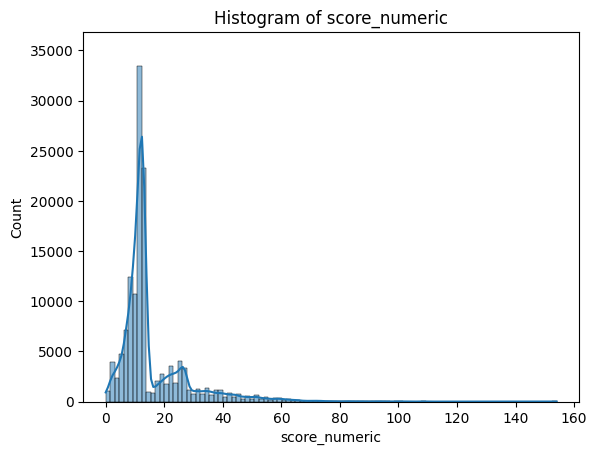

Description of score_numeric ~~~~~~~~~~
count    135751.000000
mean         15.785556
std          11.983093
min           0.000000
25%          10.000000
50%          12.000000
75%          17.000000
max         154.000000
Name: score_numeric, dtype: float64

Value counts of score_numeric ~~~~~~~~~~
score_numeric
12.0     23532
13.0     23317
10.0     10703
11.0      9960
9.0       8657
         ...  
87.0         9
81.0         9
94.0         8
102.0        8
98.0         8
Name: count, Length: 97, dtype: int64



In [6]:

# My eda boilerplate - part 2 - numeric columns
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Function to explore numeric columns with sns.histplot
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def explore_numeric_cols(col, df):
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print(f'Exploration of {col} column')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    
    series = df[col].dropna()
    # Numeric branch
    nrows = len(df)
    if nrows < 10000:
        bins = 20
    else:  
        bins = 100

    # Compute histogram heights before plotting
    counts, edges = np.histogram(series, bins=bins)
    ymax = counts.max()  

    sns.histplot(series, bins=bins, kde=True)
    plt.ylim(0, ymax*1.10)
    plt.title(f'Histogram of {col}')
    plt.grid(False)
    plt.show()
        
    print(f'Description of {col} ~~~~~~~~~~')
    print(df[col].describe())
    print()
    print(f'Value counts of {col} ~~~~~~~~~~')
    print(df[col].value_counts(dropna=False))
    print()

for col in numeric_cols:
    explore_numeric_cols(col, df)





~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of camis column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Skipping camis (unique values = 25047, exceeds threshold of 100).

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of dba column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Skipping dba (unique values = 19594, exceeds threshold of 100).

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of boro column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


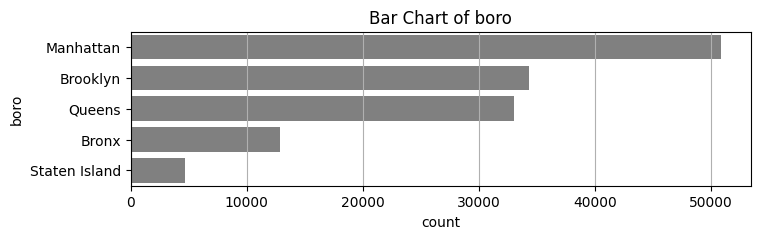

Description of boro ~~~~~~~~~~
count        135751
unique            5
top       Manhattan
freq          50861
Name: boro, dtype: object

Value counts of boro ~~~~~~~~~~
boro
Manhattan        50861
Brooklyn         34297
Queens           32990
Bronx            12884
Staten Island     4719
Name: count, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of building column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Skipping building (unique values = 7998, exceeds threshold of 100).

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of street column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Skipping street (unique values = 2617, exceeds threshold of 100).

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of zipcode column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Skipping zipcode (unique values = 218, exceeds threshold of 100).

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of phone column
~~~~~~~~~~~~~~~~~~~

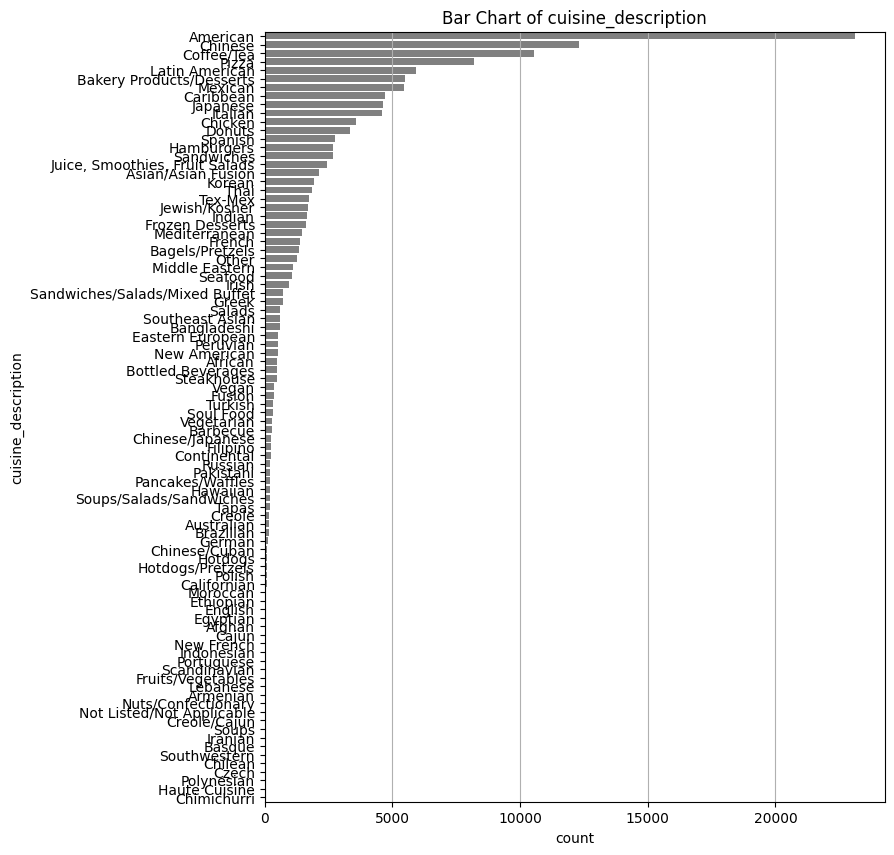

Description of cuisine_description ~~~~~~~~~~
count       135751
unique          90
top       American
freq         23121
Name: cuisine_description, dtype: object

Value counts of cuisine_description ~~~~~~~~~~
cuisine_description
American          23121
Chinese           12289
Coffee/Tea        10541
Pizza              8208
Latin American     5936
                  ...  
Chilean              13
Czech                 9
Polynesian            6
Haute Cuisine         5
Chimichurri           2
Name: count, Length: 90, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of action column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


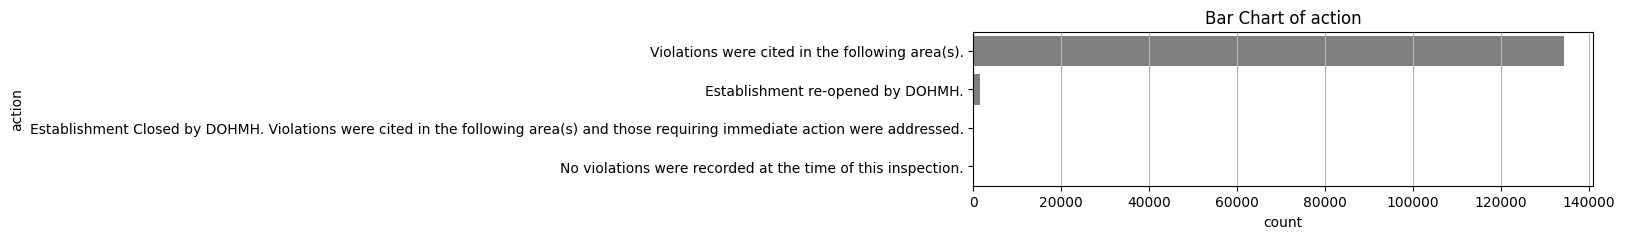

Description of action ~~~~~~~~~~
count                                              135751
unique                                                  4
top       Violations were cited in the following area(s).
freq                                               134280
Name: action, dtype: object

Value counts of action ~~~~~~~~~~
action
Violations were cited in the following area(s).                                                                                       134280
Establishment re-opened by DOHMH.                                                                                                       1452
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.        10
No violations were recorded at the time of this inspection.                                                                                9
Name: count, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of violation_

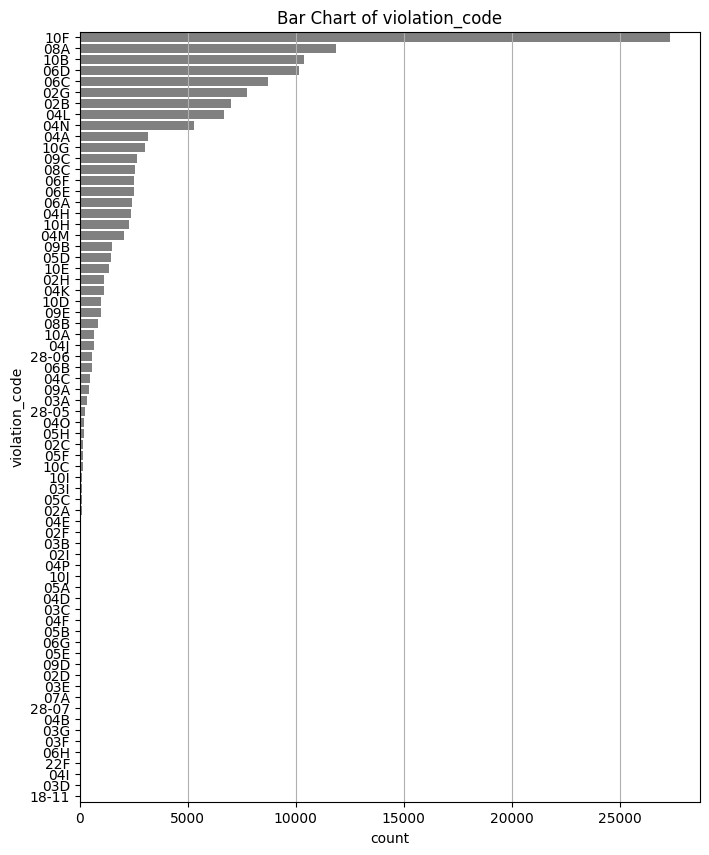

Description of violation_code ~~~~~~~~~~
count     135751
unique        70
top          10F
freq       27344
Name: violation_code, dtype: object

Value counts of violation_code ~~~~~~~~~~
violation_code
10F      27344
08A      11867
10B      10389
06D      10140
06C       8737
         ...  
06H          1
22F          1
04I          1
03D          1
18-11        1
Name: count, Length: 70, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of violation_description column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Skipping violation_description (unique values = 138, exceeds threshold of 100).

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of critical_flag column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


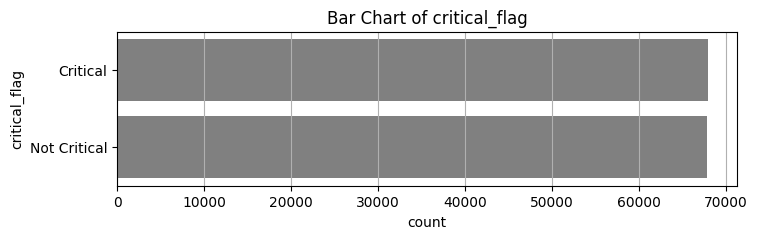

Description of critical_flag ~~~~~~~~~~
count       135751
unique           2
top       Critical
freq         67900
Name: critical_flag, dtype: object

Value counts of critical_flag ~~~~~~~~~~
critical_flag
Critical        67900
Not Critical    67851
Name: count, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of score column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


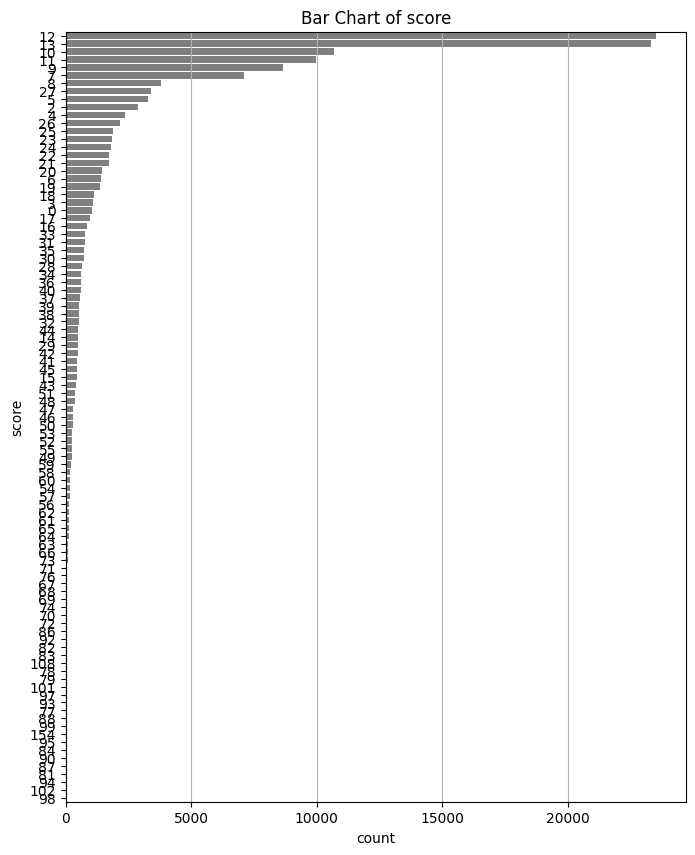

Description of score ~~~~~~~~~~
count     135751
unique        97
top           12
freq       23532
Name: score, dtype: object

Value counts of score ~~~~~~~~~~
score
12     23532
13     23317
10     10703
11      9960
9       8657
       ...  
87         9
81         9
94         8
102        8
98         8
Name: count, Length: 97, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of grade column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


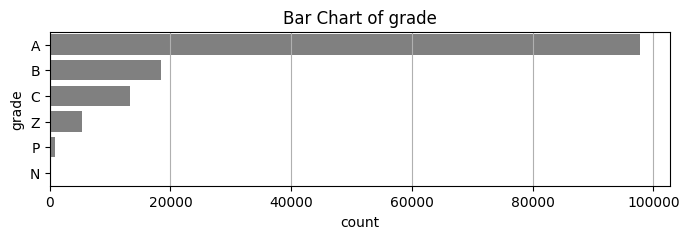

Description of grade ~~~~~~~~~~
count     135751
unique         6
top            A
freq       97812
Name: grade, dtype: object

Value counts of grade ~~~~~~~~~~
grade
A    97812
B    18412
C    13276
Z     5417
P      826
N        8
Name: count, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of inspection_type column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


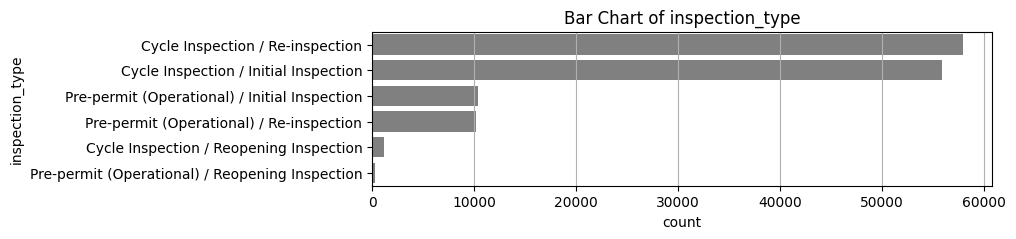

Description of inspection_type ~~~~~~~~~~
count                               135751
unique                                   6
top       Cycle Inspection / Re-inspection
freq                                 57865
Name: inspection_type, dtype: object

Value counts of inspection_type ~~~~~~~~~~
inspection_type
Cycle Inspection / Re-inspection                   57865
Cycle Inspection / Initial Inspection              55888
Pre-permit (Operational) / Initial Inspection      10358
Pre-permit (Operational) / Re-inspection           10188
Cycle Inspection / Reopening Inspection             1195
Pre-permit (Operational) / Reopening Inspection      257
Name: count, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of latitude column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Skipping latitude (unique values = 21326, exceeds threshold of 100).

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of longitude column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

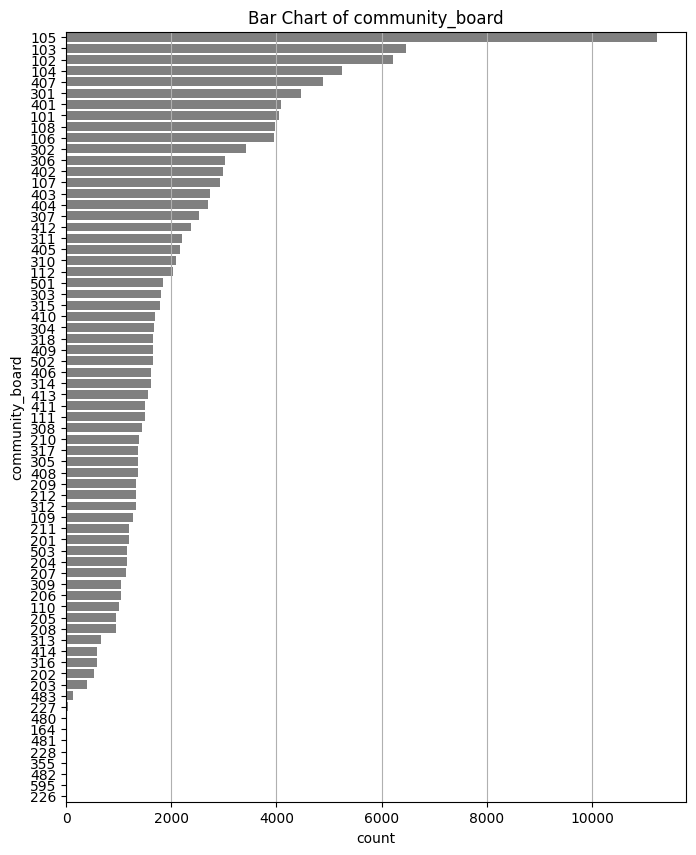

Description of community_board ~~~~~~~~~~
count     133436
unique        69
top          105
freq       11224
Name: community_board, dtype: object

Value counts of community_board ~~~~~~~~~~
community_board
105    11224
103     6456
102     6214
104     5251
407     4877
       ...  
228       18
355       12
482        6
595        2
226        1
Name: count, Length: 70, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of council_district column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


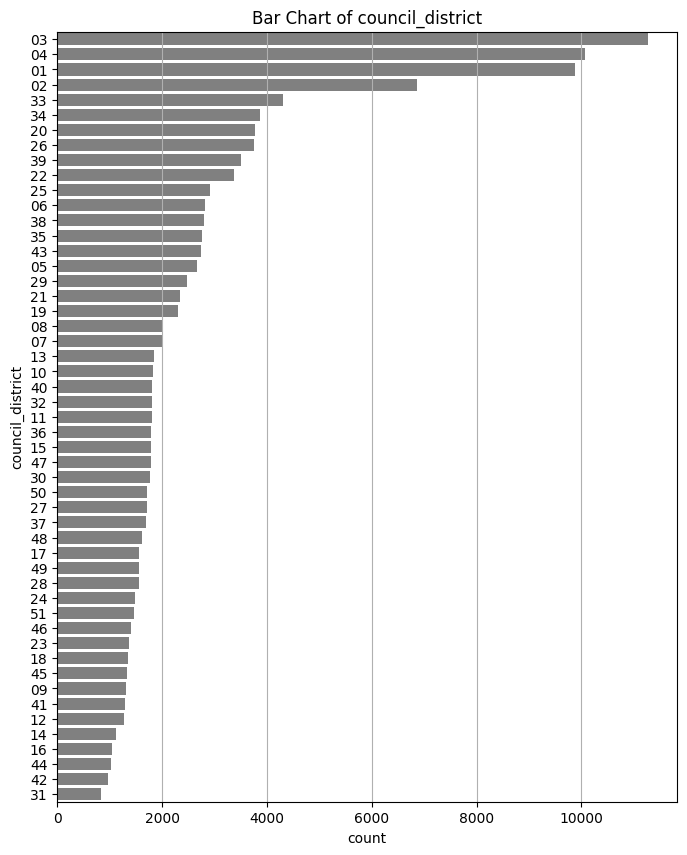

Description of council_district ~~~~~~~~~~
count     133437
unique        51
top           03
freq       11264
Name: council_district, dtype: object

Value counts of council_district ~~~~~~~~~~
council_district
03     11264
04     10074
01      9872
02      6863
33      4301
34      3873
20      3779
26      3758
39      3500
22      3382
25      2919
06      2826
38      2796
35      2754
43      2744
05      2676
29      2473
21      2343
NaN     2314
19      2296
08      2018
07      2017
13      1843
10      1829
40      1815
32      1814
11      1810
36      1795
15      1791
47      1786
30      1769
50      1717
27      1707
37      1691
48      1617
17      1566
49      1562
28      1552
24      1486
51      1459
46      1405
23      1370
18      1345
45      1325
09      1310
41      1285
12      1274
14      1123
16      1041
44      1023
42       970
31       829
Name: count, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of census_tract column
~~

In [7]:

# My eda boilerplate - part 3 - categorical columns 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Function to explore categorical columns with sns.countplot
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


def explore_categorical_cols(col, df):
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print(f'Exploration of {col} column')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    
 
    # Normal categorical branch
    unique_count = df[col].nunique()
    
    # Skip high-cardinality columns
    if unique_count > 100:
        print(f"Skipping {col} (unique values = {unique_count}, exceeds threshold of 100).")
        print()
        return
    
    plot_width = 8
    if unique_count <= 10:
        plot_height = 2
    elif unique_count <= 20:
        plot_height = 4
    else:
        plot_height = 10
    
    plt.figure(figsize=(plot_width, plot_height))
    
    max_count = df[col].value_counts().max()
    x_limit_max = max_count * 1.05
    
    sns.countplot(
        y=col,
        data=df,
        order=df[col].value_counts().index,
        color='gray'
    )
    plt.xlim(0, x_limit_max)
    plt.title(f'Bar Chart of {col}')
    plt.grid(axis='x')
    plt.show()
    
    print(f'Description of {col} ~~~~~~~~~~')
    print(df[col].describe())
    print()
    print(f'Value counts of {col} ~~~~~~~~~~')
    print(df[col].value_counts(dropna=False))
    print()


# Loop through categorical columns
for col in categorical_cols:
    explore_categorical_cols(col, df)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Exploration of DATE column: inspection_date
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


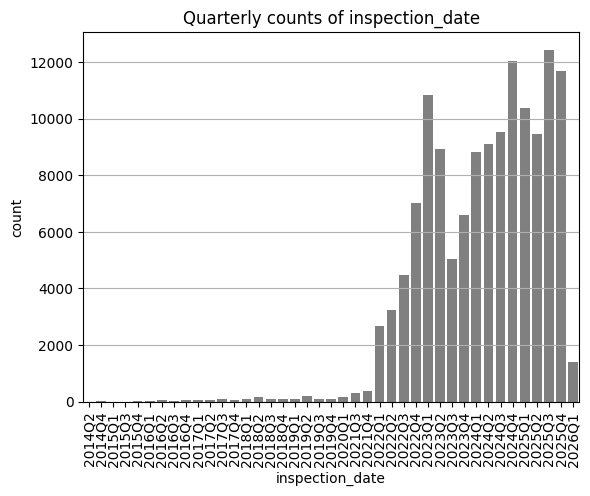

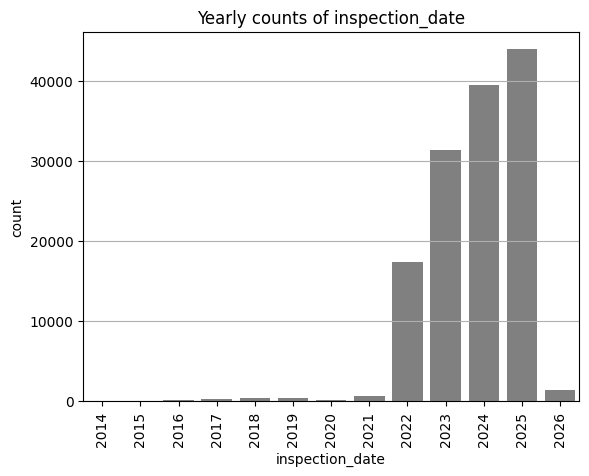

Summary of inspection_date ~~~~~~~~~~
Min date: 2014-04-21 00:00:00
Max date: 2026-01-14 00:00:00

count                           135751
mean     2024-04-14 10:22:17.890696448
min                2014-04-21 00:00:00
25%                2023-05-02 00:00:00
50%                2024-06-18 00:00:00
75%                2025-04-09 00:00:00
max                2026-01-14 00:00:00
Name: inspection_date, dtype: object

Value counts of inspection_date (by quarter) ~~~~~~~~~~
inspection_date
2025Q3    12436
2024Q4    12021
2025Q4    11662
2023Q1    10837
2025Q1    10377
2024Q3     9515
2025Q2     9459
2024Q2     9104
2023Q2     8920
2024Q1     8833
2022Q4     7018
2023Q4     6583
2023Q3     5025
2022Q3     4485
2022Q2     3253
2022Q1     2687
2026Q1     1402
2021Q4      357
2021Q3      314
2019Q2      211
2020Q1      152
2018Q2      146
2017Q3      104
2019Q3       93
2018Q4       91
2018Q1       90
2018Q3       86
2019Q1       86
2019Q4       79
2017Q4       61
2017Q1       60
2017Q2       53
2016Q4

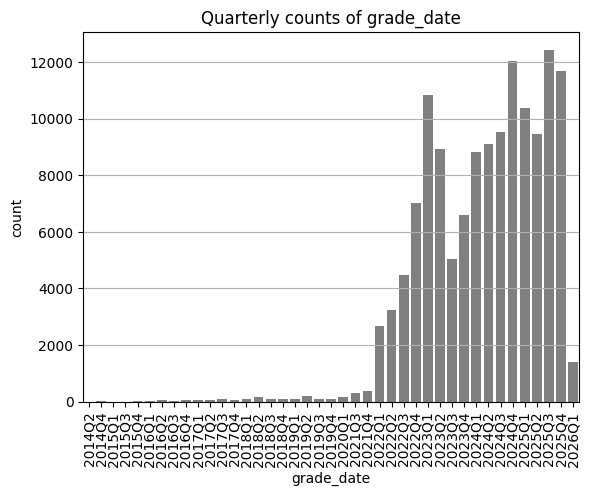

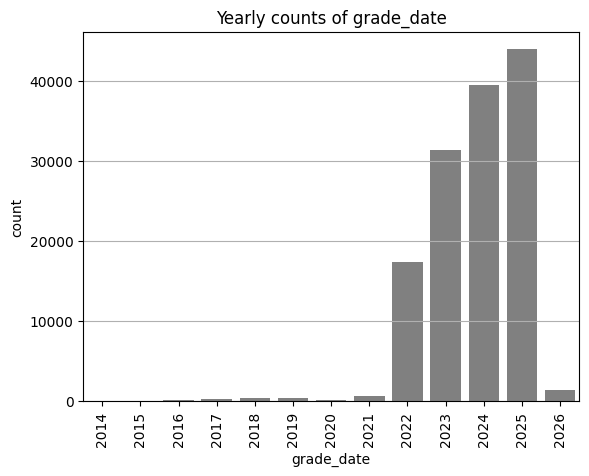

Summary of grade_date ~~~~~~~~~~
Min date: 2014-04-21 00:00:00
Max date: 2026-01-14 00:00:00

count                           135751
mean     2024-04-14 10:22:17.890696448
min                2014-04-21 00:00:00
25%                2023-05-02 00:00:00
50%                2024-06-18 00:00:00
75%                2025-04-09 00:00:00
max                2026-01-14 00:00:00
Name: grade_date, dtype: object

Value counts of grade_date (by quarter) ~~~~~~~~~~
grade_date
2025Q3    12436
2024Q4    12021
2025Q4    11662
2023Q1    10837
2025Q1    10377
2024Q3     9515
2025Q2     9459
2024Q2     9104
2023Q2     8920
2024Q1     8833
2022Q4     7018
2023Q4     6583
2023Q3     5025
2022Q3     4485
2022Q2     3253
2022Q1     2687
2026Q1     1402
2021Q4      357
2021Q3      314
2019Q2      211
2020Q1      152
2018Q2      146
2017Q3      104
2019Q3       93
2018Q4       91
2018Q1       90
2018Q3       86
2019Q1       86
2019Q4       79
2017Q4       61
2017Q1       60
2017Q2       53
2016Q4       47
2016Q2    

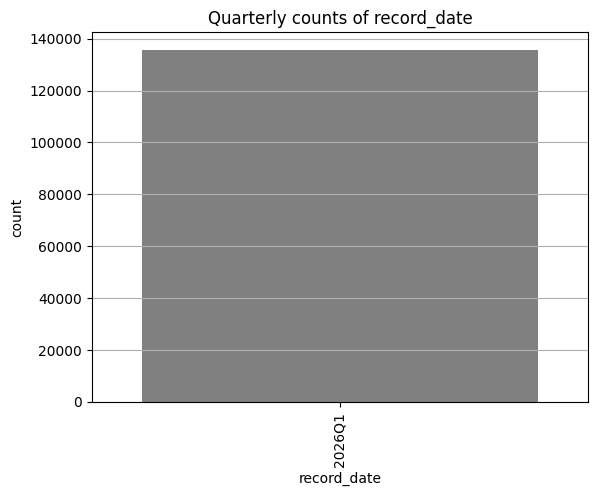

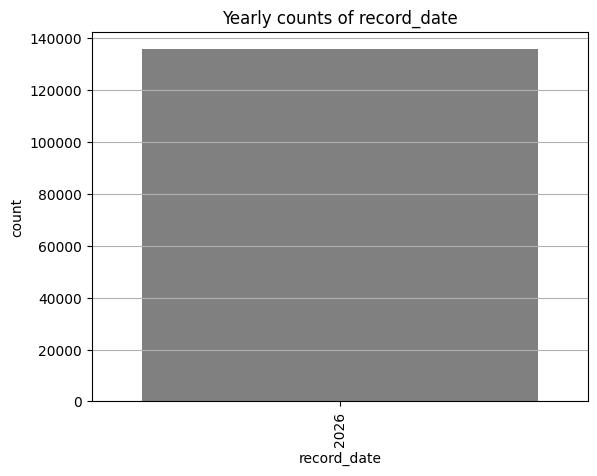

Summary of record_date ~~~~~~~~~~
Min date: 2026-01-16 00:00:00
Max date: 2026-01-16 00:00:00

count                 135751
mean     2026-01-16 00:00:00
min      2026-01-16 00:00:00
25%      2026-01-16 00:00:00
50%      2026-01-16 00:00:00
75%      2026-01-16 00:00:00
max      2026-01-16 00:00:00
Name: record_date, dtype: object

Value counts of record_date (by quarter) ~~~~~~~~~~
record_date
2026Q1    135751
Name: count, dtype: int64

Summary of record_date ~~~~~~~~~~
Min date: 2026-01-16 00:00:00
Max date: 2026-01-16 00:00:00

Value counts of record_date (by quarter) ~~~~~~~~~~
record_date
2026-01-16    135751
Name: count, dtype: int64

End of EDA. ~~~~~~~~~~


In [8]:
# My eda boilerplate - part 4 - date columns
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Function to explore date columns with sns.countplot
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def explore_date_col(col, df):
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print(f'Exploration of DATE column: {col}')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    # Only extract the column you need
    series = df[col].dropna()

    # Compute quarter without copying the full df
    quarter = series.dt.to_period('Q').astype(str)

    sns.countplot(
        x=quarter,
        order=sorted(quarter.unique()),
        color='gray'
    )
    plt.title(f'Quarterly counts of {col}')
    plt.grid(axis='y')
    plt.xticks(rotation=90)
    plt.show()

    year = series.dt.to_period('Y').astype(str)

    sns.countplot(
        x=year,
        order=sorted(year.unique()),
        color='gray'
    )
    plt.title(f'Yearly counts of {col}')
    plt.grid(axis='y')
    plt.xticks(rotation=90)
    plt.show()

    print(f"Summary of {col} ~~~~~~~~~~")
    print(f"Min date: {series.min()}")
    print(f"Max date: {series.max()}")
    print()
    print(series.describe())
    print()

    print(f"Value counts of {col} (by quarter) ~~~~~~~~~~")
    print(quarter.value_counts(dropna=False))
    print()


    # Summary stats
    print(f"Summary of {col} ~~~~~~~~~~")
    print(f"Min date: {df[col].min()}")
    print(f"Max date: {df[col].max()}")
    print()

    # Quarter value counts
    print(f"Value counts of {col} (by quarter) ~~~~~~~~~~")
    print(series.value_counts(dropna=False))
    print()


for col in date_cols:
    explore_date_col(col, df)


print ("End of EDA.", "~"*10)



In [9]:
# Delete df to free memory
df = None

# <a id='toc8_'></a>[Further understanding of data](#toc0_)


In [10]:
# Understanding camis and dba combinations
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

camis_dba_counts = (
    resto_clean.groupby(["camis", "dba"])
    .size()
    .reset_index(name="count_rows")
    .sort_values("camis")
)

print(camis_dba_counts)

# Camis are not unique so use count instead of count(distinct).


          camis                          dba  count_rows
0      30075445        MORRIS PARK BAKE SHOP           8
1      30191841                D.J. REYNOLDS           4
2      40356018             RIVIERA CATERERS           2
3      40356483           WILKEN'S FINE FOOD          10
4      40356731  TASTE THE TROPICS ICE CREAM           9
...         ...                          ...         ...
25042  50179650          KANOXXO CAFE & DELI           2
25043  50179690          MONTE CAFE & BAKERY           2
25044  50179743    HOUSE OF MANDI RESTAURANT           2
25045  50179941             SUB01 FOOD CORP.           2
25046  50179991                         NATA           2

[25047 rows x 3 columns]


<Figure size 1400x600 with 0 Axes>

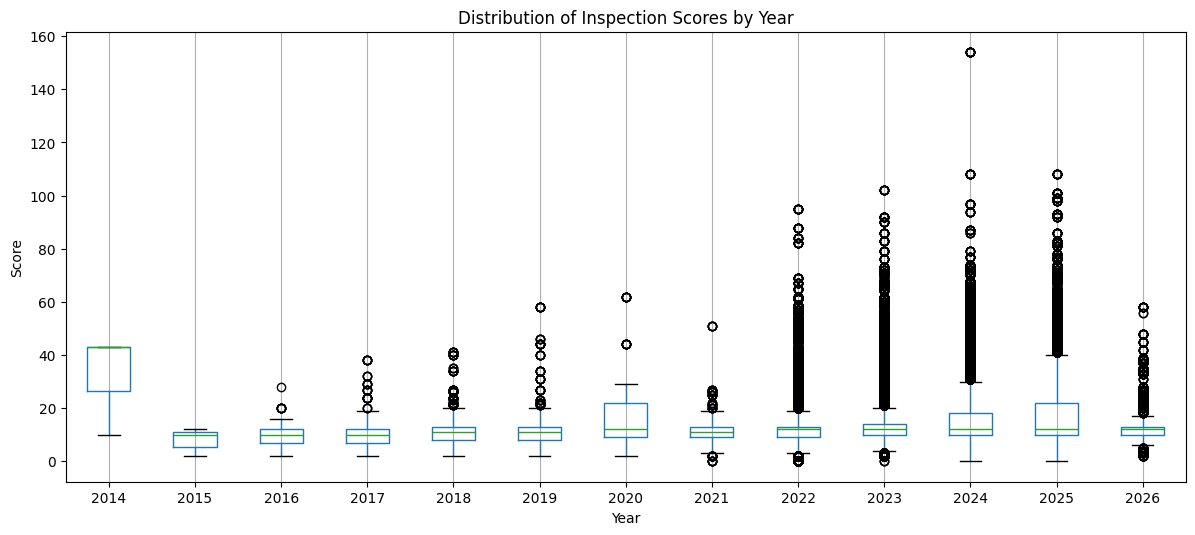

In [11]:
# Boxplot of score_numeric by year
resto_clean['year'] = resto_clean['inspection_date'].dt.year

plt.figure(figsize=(14, 6))
resto_clean.boxplot(column='score_numeric', by='year', figsize=(14, 6))
plt.title('Distribution of Inspection Scores by Year')
plt.suptitle('')  # Remove the automatic title
plt.xlabel('Year')
plt.ylabel('Score')
plt.grid(axis='y')
plt.show()

## <a id='toc8_1_'></a>[Create resto_joined after standardizing cuisine, violation and neighborhoods using nta_codes](#toc0_)

In [12]:
# Standardize cuisine descriptions, violation group names, and provide neighborhood names
# Load Dim tables and create resto_joined as df moving forward.

dim_cuisine = pd.read_csv("dim_tables/dim_cuisine.csv", dtype=str)
print("Dataframe dim_cuisine loaded.")
print(dim_cuisine.head(5))

dim_violation = pd.read_csv("dim_tables/dim_violation_pg.csv", encoding = "latin1", dtype=str)
print("Dataframe dim_violation loaded.")
print(dim_violation.head(5))

dim_nta = pd.read_csv("dim_tables/dim_nta.csv", dtype=str)
print("Dataframe dim_nta loaded.")
print(dim_nta.head(5))

print("\nDimension tables loaded.", "~"*10, "\n")

resto_joined = resto_clean.merge(dim_cuisine, on="cuisine_description", how="left") \
    .merge(dim_violation, on="violation_code", how="left") \
    .merge(dim_nta, left_on="nta", right_on="nta_code", how="left")
print("Dataframe resto_joined created with joins to dimension tables.", "~"*10, "\n")
print("Joined resto_clean with dimension tables.", "~"*10, "\n")
print(resto_joined.columns.tolist())


Dataframe dim_cuisine loaded.
  cuisine_description                 cuisine_group
0              Afghan  Middle Eastern/North African
1             African                       African
2            American                      American
3            Armenian  Middle Eastern/North African
4  Asian/Asian Fusion                   Asian Other
Dataframe dim_violation loaded.
  violation_code                              violation_description  \
0            02A   Food not cooked to required minimum temperature.   
1            02B         Hot food item not held at or above 140õ F.   
2            02C  Hot food item that has been cooked and refrige...   
3            02D  Commercially processed pre-cooked TCS in herme...   
4            02F  Meat, fish or molluscan shellfish served raw o...   

  code_group            violation_group  
0          2  Temperature Control (TCS)  
1          2  Temperature Control (TCS)  
2          2  Temperature Control (TCS)  
3          2  Temperature Contr

# <a id='toc9_'></a>[EXPLORATORY ANALYSIS USING PYTHON](#toc0_)
- Overview - yearly 
- Yearly data cross-tab (columns)
- Analyze by cuisine_group, nta_name neighborhood and borough (rows)

- Percent critical violations and top 10 in 2025
- Average scores and top 10 in 2025
- Percent grade A and top 5


## <a id='toc9_1_'></a>[Percent Critical Violations and Top 10 in 2025](#toc0_)

In [13]:
# % critical violations by cuisine group cross-tab by year
print("Calculating percent critical violations by cuisine_group, cross-tab by year...", "~"*10, "\n")

# By cuisine_group and year
pct_critical_by_cuisine_year = (
    resto_joined[resto_joined['critical_flag'] == 'Critical']
    .groupby(['cuisine_group', resto_joined['inspection_date'].dt.year])
    .size()
    / resto_joined.groupby(['cuisine_group', resto_joined['inspection_date'].dt.year]).size()
    * 100
).unstack(fill_value=0).sort_values(by=2025, ascending=False)

print("\nPercent Critical Violations by Cuisine Group and Year:")
print(pct_critical_by_cuisine_year)

print("\nTop10 Cuisine Groups by Percent Critical Violations in 2025:")
print(pct_critical_by_cuisine_year[2025].head(10))



Calculating percent critical violations by cuisine_group, cross-tab by year... ~~~~~~~~~~ 


Percent Critical Violations by Cuisine Group and Year:
inspection_date                    2014       2015       2016        2017  \
cuisine_group                                                               
South Asian                    0.000000   0.000000   0.000000    0.000000   
African                        0.000000   0.000000   0.000000   66.666667   
Southeast Asian                0.000000   0.000000   0.000000    0.000000   
Asian Other                    0.000000   0.000000   0.000000    0.000000   
East Asian                     0.000000   0.000000  62.500000   33.333333   
Chinese                        0.000000   0.000000   0.000000   80.000000   
Mediterranean                  0.000000   0.000000  33.333333  100.000000   
Latin American/Caribbean       0.000000   0.000000  22.222222   69.565217   
Jewish/Kosher                  0.000000   0.000000   0.000000         NaN   
Europ

In [14]:
# % critical violations by borough and year
print("Calculating percent critical violations by borough, cross-tab by year...", "~"*10, "\n")
# By borough and year
pct_critical_by_borough_year = (
    resto_joined[resto_joined['critical_flag'] == 'Critical']
    .groupby(['boro', resto_joined['inspection_date'].dt.year])
    .size()
    / resto_joined.groupby(['boro', resto_joined['inspection_date'].dt.year]).size()
    * 100
).unstack(fill_value=0).sort_values(by=2025, ascending=False)

print("\nPercent Critical Violations by Borough and Year:")
print(pct_critical_by_borough_year)

print("\nTop 10 Boroughs by Percent Critical Violations in 2025:")
print(pct_critical_by_borough_year[2025].head(10))

Calculating percent critical violations by borough, cross-tab by year... ~~~~~~~~~~ 


Percent Critical Violations by Borough and Year:
inspection_date       2014  2015       2016       2017       2018       2019  \
boro                                                                           
Staten Island     0.000000   0.0  62.500000  53.846154  54.166667  62.500000   
Queens            0.000000  50.0  52.500000  44.230769  44.444444  47.794118   
Bronx             0.000000   0.0  40.000000  57.142857  50.000000  47.619048   
Manhattan         0.000000  25.0  43.396226  49.473684  50.980392  43.790850   
Brooklyn         85.714286  25.0  37.500000  51.923077  50.704225  48.888889   

inspection_date       2020       2021       2022       2023       2024  \
boro                                                                     
Staten Island    50.000000  43.750000  48.450704  48.611111  49.637681   
Queens           42.028986  45.070423  52.055878  50.131379  50.570383   
Bronx  

In [15]:
# % critical violations by neighborhood (nta_name) and year
print("Calculating percent critical violations by neighborhood, cross-tab by year...", "~"*10, "\n")
# By nta_name and year
pct_critical_by_nta_year = (
    resto_joined[resto_joined['critical_flag'] == 'Critical']
    .groupby(['nta_name', resto_joined['inspection_date'].dt.year])
    .size()
    / resto_joined.groupby(['nta_name', resto_joined['inspection_date'].dt.year]).size()
    * 100
).unstack(fill_value=0).sort_values(by=2025, ascending=False)

print("\nPercent Critical Violations by NTA (Neighborhood) and Year:")
print(pct_critical_by_nta_year)

top10 = (
    pct_critical_by_nta_year[2025]
    .head(10)
    .rename("pct_critical_2025")
    .reset_index()          
)

pct_critical_by_nta_2025_top10 = top10.merge(
    dim_nta[['nta_name', 'borough']],
    on='nta_name',
    how='left'
)

print(pct_critical_by_nta_2025_top10)



Calculating percent critical violations by neighborhood, cross-tab by year... ~~~~~~~~~~ 


Percent Critical Violations by NTA (Neighborhood) and Year:
inspection_date                                     2014  2015       2016  \
nta_name                                                                    
Arden Heights                                        0.0   0.0   0.000000   
Annadale-Huguenot-Prince's Bay-Eltingville           0.0   0.0   0.000000   
park-cemetery-etc-Queens                             0.0   0.0   0.000000   
Mariner's Harbor-Arlington-Port Ivory-Graniteville   0.0   0.0  50.000000   
Fresh Meadows-Utopia                                 0.0   0.0   0.000000   
...                                                  ...   ...        ...   
Hammels-Arverne-Edgemere                             0.0   0.0   0.000000   
Airport                                              0.0   0.0  50.000000   
park-cemetery-etc-Manhattan                          0.0   0.0  66.666667   
p

## <a id='toc9_2_'></a>[Focus on year 2025 only](#toc0_)


### <a id='toc9_2_1_'></a>[Violations](#toc0_)

- Analyze Violation types
- Total most common violations
- Total violations over time, by cuisine_group, by neighborhood, by borough
- Average scores and top 10 in 2025
- Percent grade A and top 5

In [16]:
# Filtering 2025 only
resto_j2025 = resto_joined[resto_joined['inspection_date'].dt.year == 2025].copy()
print (resto_j2025['inspection_date'].head())
print(resto_j2025.columns)


1    2025-11-28
8    2025-07-08
9    2025-04-09
14   2025-09-02
15   2025-04-15
Name: inspection_date, dtype: datetime64[ns]
Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'cuisine_description', 'inspection_date', 'action', 'violation_code',
       'violation_description_x', 'critical_flag', 'score', 'grade',
       'grade_date', 'record_date', 'inspection_type', 'latitude', 'longitude',
       'community_board', 'council_district', 'census_tract', 'bin', 'bbl',
       'nta', 'Location', 'score_numeric', 'year', 'cuisine_group',
       'violation_description_y', 'code_group', 'violation_group', 'nta_code',
       'nta_name', 'borough'],
      dtype='object')


In [17]:
# Get the top 10 highest violation descriptions from resto_j2025
df_top_10_violations = pd.DataFrame(
    resto_j2025['violation_description_y']
    .value_counts()
    .head(10)
)

print("Top 10 Most Common Violation Descriptions in 2025:")
df_top_10_violations

Top 10 Most Common Violation Descriptions in 2025:


,count
violation_description_y,
"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",8692
Anti-siphonage or back-flow prevention device not provided where required; equipment or floor not properly drained; sewage disposal system in disrepair or not functioning properly. Condensation or liquid waste improperly disposed of.,3507
"Establishment is not free of harborage or conditions conducive to rodents, insects or other pests.",3414
"Food not protected from potential source of contamination during storage, preparation, transportation, display or service.",3124
"Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.",3042
Cold food item held above 41õ F (smoked fish and reduced oxygen packaged foods above 38 õF) except during necessary preparation.,2720
Hot food item not held at or above 140õ F.,2351
Evidence of mice or live mice in establishment's food or non-food areas.,1877
"Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility?s food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.",1484


- Total violations over time, by borough and cuisine_group

In [18]:
# Get yearly total violations by borough and for total, groupby() and size()
violations_by_borough_year = (
    resto_joined.groupby(['boro', resto_joined['inspection_date'].dt.year])
    .size()
    .unstack(fill_value=0)
)

print("Total Violations by Borough and Year:")
print(violations_by_borough_year)

print("\nTop Total Violations by Borough in 2025:")
print(violations_by_borough_year[2025].sort_values(ascending=False))

Total Violations by Borough and Year:
inspection_date  2014  2015  2016  2017  2018  2019  2020  2021  2022   2023  \
boro                                                                           
Bronx               0     0     5    14    12    21     4    38  1295   3067   
Brooklyn            7     4    24    52    71   135    15   187  4765   7811   
Manhattan           0     8    53    95   153   153    62   272  6879  11960   
Queens              0     2    40   104   153   136    69   142  3794   7231   
Staten Island       0     0     8    13    24    24     2    32   710   1296   

inspection_date   2024   2025  2026  
boro                                 
Bronx             3811   4513   104  
Brooklyn         10408  10501   317  
Manhattan        14582  16055   589  
Queens            9292  11675   352  
Staten Island     1380   1190    40  

Top Total Violations by Borough in 2025:
boro
Manhattan        16055
Queens           11675
Brooklyn         10501
Bronx             4

In [19]:
# Get yearly total violations by borough and for total, groupby() and size()
violations_by_cuisine_year = (
    resto_joined.groupby(['cuisine_group', resto_joined['inspection_date'].dt.year])
    .size()
    .unstack(fill_value=0)
)

print("Total Violations by Cuisine and Year:")
print(violations_by_cuisine_year)

print("\nTop Total Violations by Cuisine in 2025:")
print(violations_by_cuisine_year[2025].sort_values(ascending=False))

Total Violations by Cuisine and Year:
inspection_date               2014  2015  2016  2017  2018  2019  2020  2021  \
cuisine_group                                                                  
African                          0     0     0     3     4     6     2     0   
American                         0    10    80   150   204   221    73   147   
Asian Other                      0     0     0     0     3     0     2     2   
Bakery/Desserts                  7     1     0     7     7     5     2    45   
Beverages                        0     0     4    15    20    22     1    60   
Chinese                          0     0     0     5    10    19     5    53   
East Asian                       0     0     8     6    26    13     9    26   
European                         0     0    11    35    47    31    21   143   
Fast Food                        0     3     4     7    19    10     2    31   
Fusion/Contemporary              0     0     0     0     0     0     0     0   
Je

Grade Distribution by Year:
grade                A     B     C  N    P     Z
inspection_date                                 
2014                 2     0     5  0    0     0
2015                13     0     0  0    1     0
2016               116    11     3  0    0     0
2017               237    25    14  0    2     0
2018               317    66    24  2    4     0
2019               384    40    43  0    1     1
2020               107    18    27  0    0     0
2021               587    62    10  0   12     0
2022             13574  2247  1402  0  215     5
2023             23111  4908  3053  0  231    62
2024             28439  5870  4634  0  225   305
2025             29844  5165  4061  6  135  4723
2026              1081     0     0  0    0   321


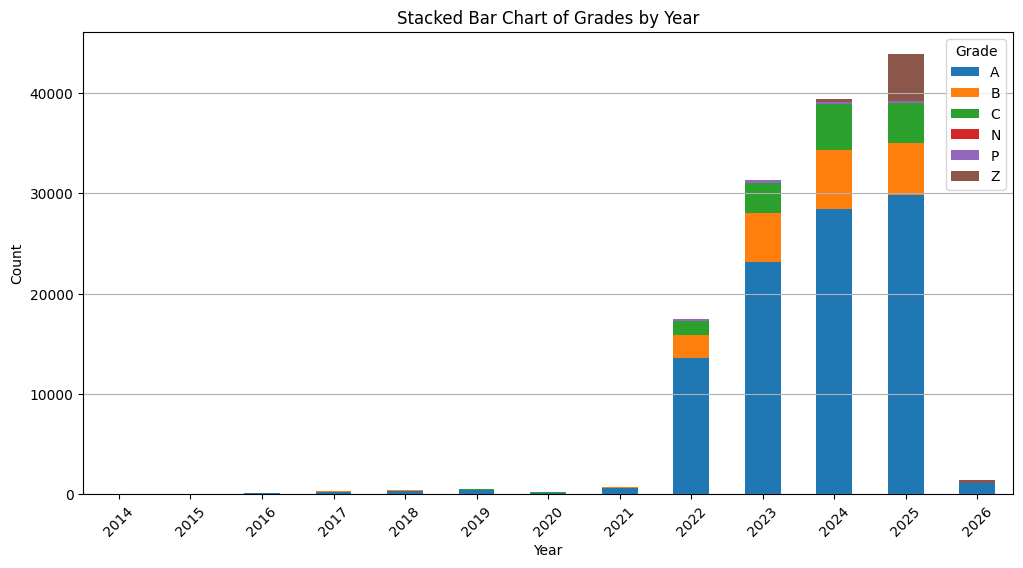

In [20]:
# Create stacked bar chart of yearly grades from resto_joined
grades_by_year = (
    resto_joined.groupby([resto_joined['inspection_date'].dt.year, 'grade'])
    .size()
    .unstack(fill_value=0)
)

print("Grade Distribution by Year:")
print(grades_by_year)

# Create stacked bar chart
grades_by_year.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stacked Bar Chart of Grades by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Grade')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### <a id='toc9_2_2_'></a>[Average scores and top 10 in 2025](#toc0_)
- Percent grade A and top 5

In [21]:
# Calculate average scores and percent grade A by cuisine group for 2025

# Average scores by cuisine group
avg_scores_by_cuisine = (
    resto_j2025.groupby('cuisine_group')['score_numeric']
    .mean()
    .sort_values(ascending=False)
    .round(2)
)

print("Average Scores by Cuisine Group in 2025:")
print(avg_scores_by_cuisine)
print()

# Percent Grade A by cuisine group
pct_grade_a_by_cuisine = (
    (resto_j2025['grade'] == 'A').groupby(resto_j2025['cuisine_group']).sum() 
    / resto_j2025.groupby('cuisine_group').size() 
    * 100
).sort_values(ascending=False).round(2)

print("Percent Grade A by Cuisine Group in 2025:")
print(pct_grade_a_by_cuisine)

Average Scores by Cuisine Group in 2025:
cuisine_group
South Asian                     28.74
African                         23.00
Southeast Asian                 21.55
Chinese                         20.84
Asian Other                     19.78
Middle Eastern/North African    19.70
Latin American/Caribbean        19.46
Vegetarian/Vegan                19.34
East Asian                      18.46
Jewish/Kosher                   17.58
European                        17.03
Seafood                         16.47
Mediterranean                   15.87
Fusion/Contemporary             15.68
American                        15.38
Light Meals                     14.80
Beverages                       14.47
Fast Food                       14.06
Bakery/Desserts                 13.81
Other/Not Specified             12.54
Name: score_numeric, dtype: float64

Percent Grade A by Cuisine Group in 2025:
cuisine_group
Other/Not Specified             84.75
Bakery/Desserts                 79.73
Beverages       

In [22]:
# Calculate average scores and percent grade A by borough for 2025

# Average scores by borough
avg_scores_by_borough = (
    resto_j2025.groupby('boro')['score_numeric']
    .mean()
    .sort_values(ascending=False)
    .round(2)
)

print("Average Scores by Borough in 2025:")
print(avg_scores_by_borough)
print()

# Percent Grade A by borough
pct_grade_a_by_borough = (
    (resto_j2025['grade'] == 'A').groupby(resto_j2025['boro']).sum() 
    / resto_j2025.groupby('boro').size() 
    * 100
).sort_values(ascending=False).round(2)

print("Percent Grade A by Borough in 2025:")
print(pct_grade_a_by_borough)

Average Scores by Borough in 2025:
boro
Queens           19.14
Bronx            16.67
Manhattan        16.52
Brooklyn         16.48
Staten Island    16.11
Name: score_numeric, dtype: float64

Percent Grade A by Borough in 2025:
boro
Staten Island    72.94
Manhattan        70.83
Brooklyn         69.97
Bronx            69.18
Queens           61.11
dtype: float64


Average Inspection Scores by Year:
inspection_date
2014    33.57
2015     8.21
2016     9.90
2017    11.10
2018    12.89
2019    13.18
2020    16.73
2021    11.21
2022    13.43
2023    15.06
2024    16.04
2025    17.21
2026    14.61
Name: score_numeric, dtype: float64


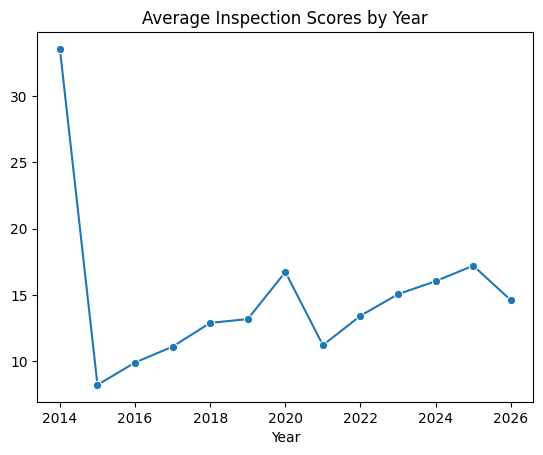

In [23]:
# Calculate average scores by year and use lineplot
avg_scores_by_year = (
    resto_joined.groupby(resto_joined['inspection_date'].dt.year)['score_numeric']
    .mean()
    .round(2)
)

sns.lineplot(x=avg_scores_by_year.index, y=avg_scores_by_year.values, marker='o')
plt.title('Average Inspection Scores by Year')
plt.xlabel('Year')
print("Average Inspection Scores by Year:")
print(avg_scores_by_year)